In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import time
import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

In [4]:
# Define the Google Drive path
google_drive_path = '/content/drive/MyDrive/dataset2'
# Ensure the directory exists
os.makedirs(google_drive_path, exist_ok=True)

In [5]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
classifier_model = mobilenet_v2

In [23]:
# Define the training and validation base directories
train_dir = os.path.join(google_drive_path, 'train1')
validation_dir = os.path.join(google_drive_path, 'validation1')
test_dir = os.path.join(google_drive_path, 'test1')

In [24]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(train_dir),
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(validation_dir),
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

#str(test_dir) digunakan untuk mengonversi jalur direktori test_dir menjadi string.
#Fungsi tf.keras.utils.image_dataset_from_directory mengharapkan input berupa string yang mewakili
#jalur direktori tempat data gambar berada.

#seed=123 adalah argumen opsional yang menetapkan nilai seed untuk generator acak.
#Seed digunakan agar hasil acak yang dihasilkan oleh TensorFlow menjadi dapat direproduksi.
#Dengan kata lain, jika Anda menjalankan ulang kode ini, Anda akan mendapatkan hasil yang sama jika
#menggunakan seed yang sama.
#Sebagai contoh, jika Anda memiliki seed yang sama pada dua eksekusi yang berbeda, Anda akan mendapatkan
#pengacakan yang identik. Ini bermanfaat ketika Anda ingin hasil eksperimen yang konsisten setiap kali Anda
#menjalankan model atau kode yang melibatkan pengacakan

test_ds = tf.keras.utils.image_dataset_from_directory(
  str(test_dir),
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 704 files belonging to 8 classes.
Found 88 files belonging to 8 classes.
Found 88 files belonging to 8 classes.


In [25]:
class_names = np.array(train_ds.class_names)
print(class_names)

['aluvial' 'andosol' 'entisol' 'humus' 'inceptisol' 'kapur' 'laterit'
 'pasir']


In [26]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Caching (cache()):

Panggilan cache() pada objek dataset (train_ds, val_ds, dan test_ds) menyimpan dataset ke dalam memori setelah membaca data dari disk pada kali pertama. Ini membantu mempercepat akses ke data pada iterasi-iterasi berikutnya karena data sekarang tersimpan di dalam memori RAM dan tidak perlu dibaca dari disk lagi.
Prefetching (prefetch(buffer_size=AUTOTUNE)):

Prefetching memungkinkan pengambilan data berikutnya untuk dilakukan secara paralel dengan pelatihan model. Dengan kata lain, sementara satu batch data sedang digunakan oleh model untuk pelatihan, TensorFlow akan memuat dan mempersiapkan batch berikutnya secara simultan. Ini membantu meminimalkan waktu idle CPU dan GPU, sehingga pelatihan dapat dilakukan lebih efisien.
Parameter buffer_size menentukan jumlah batch yang akan di-cache (dimuat) di memori. Penggunaan AUTOTUNE berarti TensorFlow akan secara otomatis menyesuaikan ukuran buffer berdasarkan kapasitas sistem dan sumber daya yang tersedia.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [13]:
result_batch = classifier.predict(train_ds)

22/22 [==============================] - 63s 3s/step


In [15]:
#labels_path = '/content/drive/MyDrive/dataset1/label.txt'
#imagenet_labels = np.array(open(labels_path).read().splitlines())

feature_extractor_model: Model yang akan digunakan sebagai feature extractor, dalam hal ini, MobileNet V2.
input_shape=(224, 224, 3): Bentuk input yang diharapkan oleh model, yaitu gambar berukuran 224x224 piksel dengan 3 saluran warna (RGB).
trainable=False: Mengatur agar parameter (bobot) model tidak dapat di-train ulang selama proses pelatihan. Dengan kata lain, bobot dari model MobileNet V2 yang telah dilatih sebelumnya akan tetap konstan selama pelatihan model utama.

In [14]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_model = mobilenet_v2

In [15]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [16]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


Feature Extractor Layer (feature_extractor_layer): Ini adalah lapisan yang telah Anda definisikan sebelumnya untuk mengekstraksi fitur dari gambar.
**Dense Layer (tf.keras.layers.Dense(num_classes)'):** Ini adalah lapisan klasifikasi yang memiliki jumlah unit (neuron) sesuai dengan num_classes`. Lapisan ini menghubungkan vektor fitur yang dihasilkan oleh lapisan feature extractor ke output kelas. Fungsi aktivasi default untuk lapisan Dense adalah linear, yang berarti keluarannya tidak mengalami transformasi non-linear pada tahap ini.

 Jika tidak diberikan secara eksplisit, lapisan Dense dalam TensorFlow secara default menggunakan fungsi aktivasi linear.

In [27]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes,activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 8)                 10248     
                                                                 
Total params: 2268232 (8.65 MB)
Trainable params: 10248 (40.03 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [33]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1)

In [34]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
22/22 [==============================] - 41s 2s/step - loss: 0.2457 - acc: 0.9460 - val_loss: 0.1487 - val_acc: 0.9773
Epoch 2/10
22/22 [==============================] - 35s 1s/step - loss: 0.1581 - acc: 0.9801 - val_loss: 0.0968 - val_acc: 1.0000
Epoch 3/10
22/22 [==============================] - 37s 2s/step - loss: 0.1199 - acc: 0.9901 - val_loss: 0.0840 - val_acc: 1.0000
Epoch 4/10
22/22 [==============================] - 35s 2s/step - loss: 0.0958 - acc: 0.9915 - val_loss: 0.0683 - val_acc: 1.0000
Epoch 5/10
22/22 [==============================] - 37s 2s/step - loss: 0.0759 - acc: 0.9972 - val_loss: 0.0603 - val_acc: 1.0000
Epoch 6/10
22/22 [==============================] - 35s 2s/step - loss: 0.0622 - acc: 1.0000 - val_loss: 0.0505 - val_acc: 1.0000
Epoch 7/10
22/22 [==============================] - 38s 1s/step - loss: 0.0524 - acc: 1.0000 - val_loss: 0.0436 - val_acc: 1.0000
Epoch 8/10
22/22 [==============================] - 39s 2s/step - loss: 0.0454 - acc: 1.00

In [44]:
def show_images_with_predictions(images, true_labels, predicted_labels, class_names):
    num_images = images.shape[0]
    num_cols = 4  # Jumlah kolom yang diinginkan
    num_rows = num_images // num_cols + 1  # Hitung jumlah baris yang dibutuhkan
    plt.figure(figsize=(15, 5 * num_rows))

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i])
        plt.title(f'True: {class_names[true_labels[i]]}\nPredicted: {class_names[predicted_labels[i]]}')
        plt.axis('off')

    plt.show()


3/3 [==============================] - 5s 1s/step - loss: 0.0918 - acc: 0.9886
Test Loss: 0.09177901595830917, Test Accuracy: 0.9886363744735718


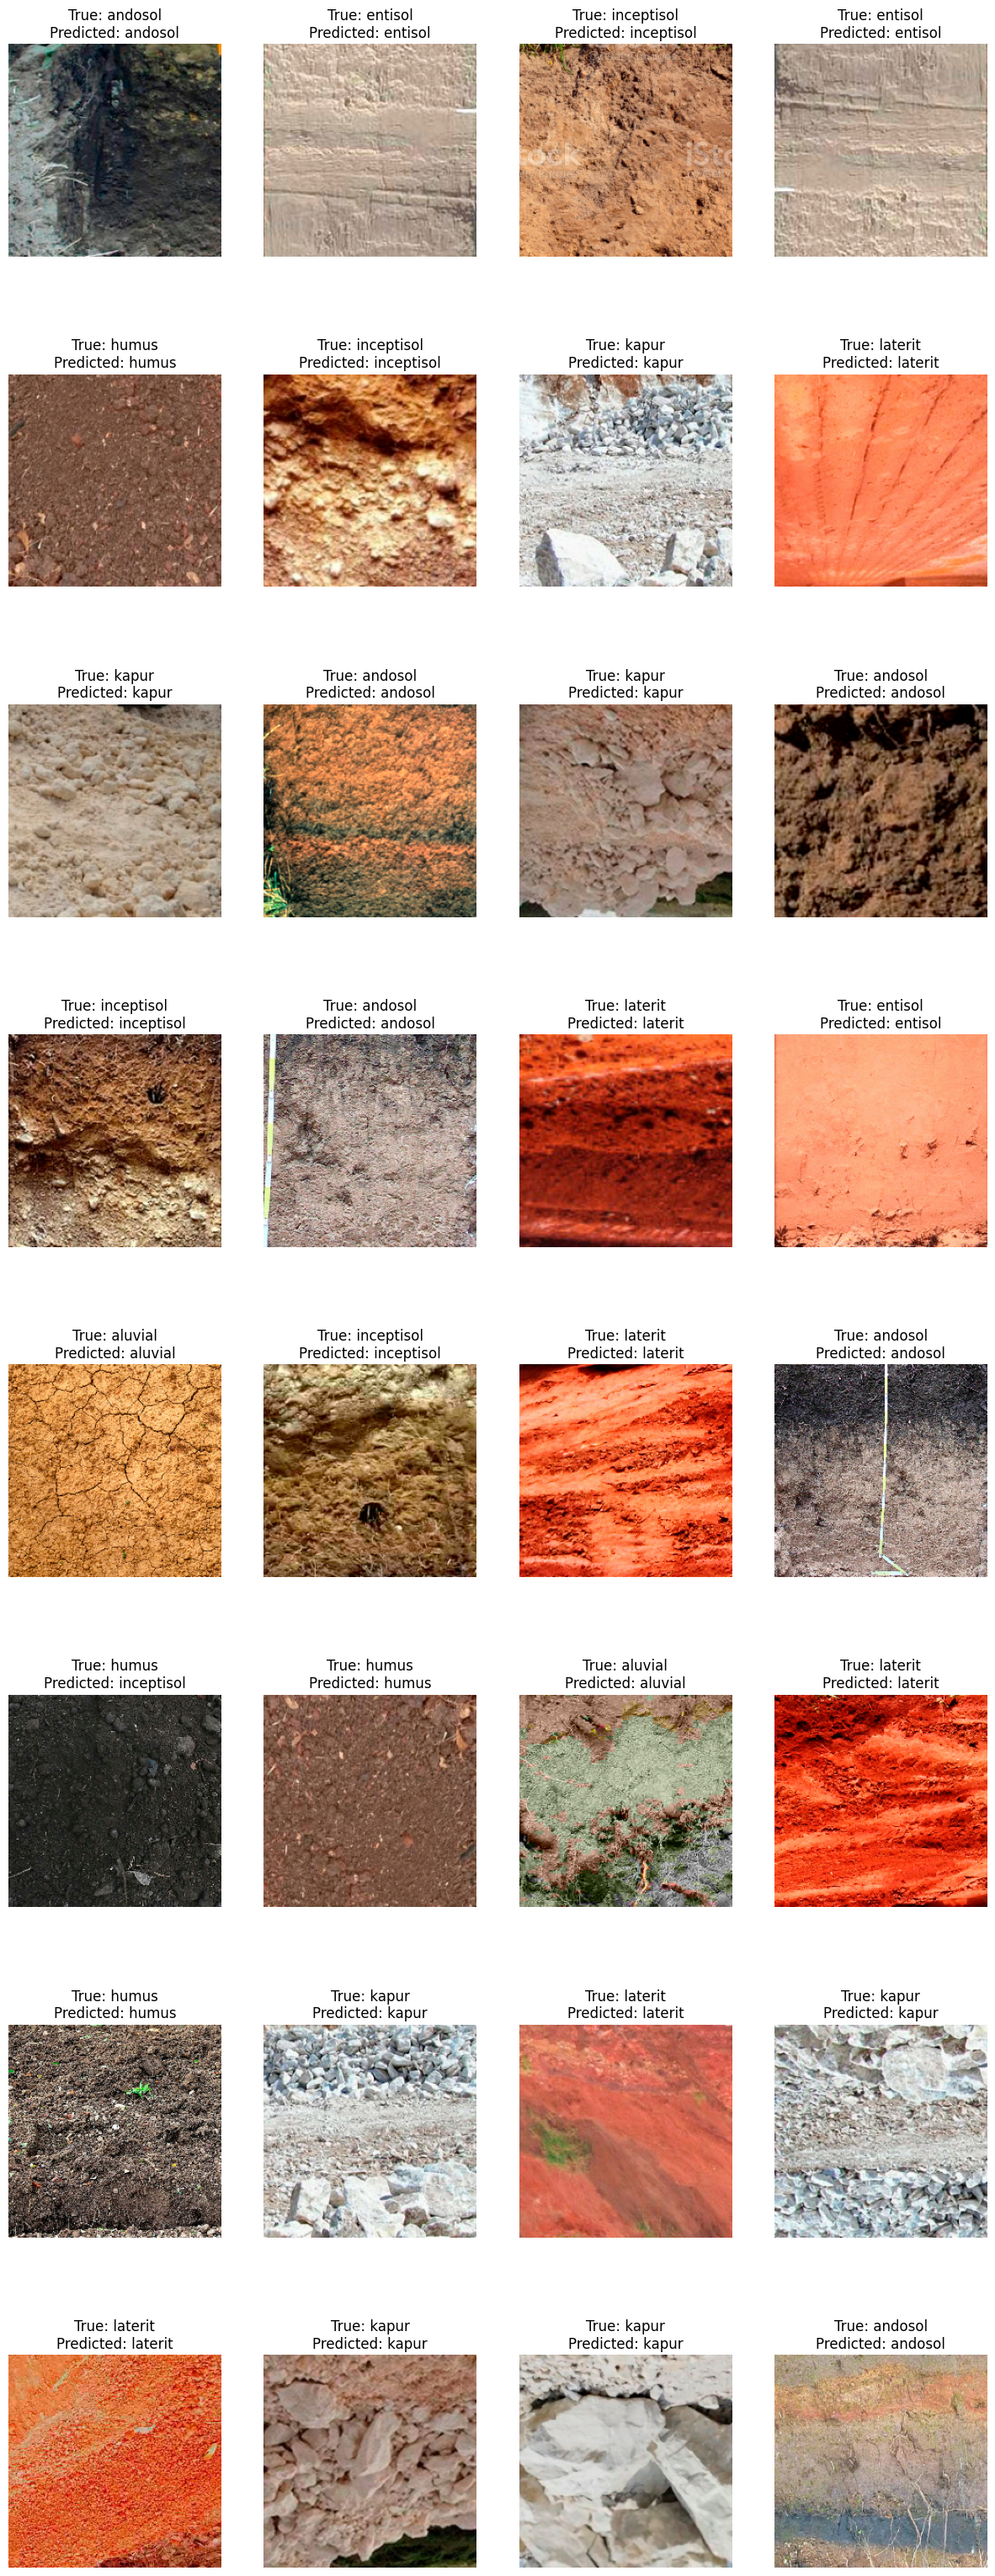

In [45]:
# Get a batch of test images and labels
test_images, test_labels = next(iter(test_ds))

# Make predictions on the test batch
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Convert TensorFlow dataset to NumPy array
test_images = np.array(test_images)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Show images with true and predicted labels
show_images_with_predictions(test_images, test_labels, predicted_labels, class_names)


In [46]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

'/tmp/saved_models/1700819055'

In [47]:
reloaded = tf.keras.models.load_model(export_path)

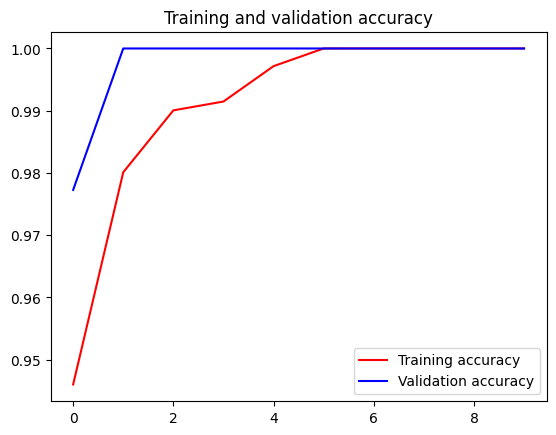

<Figure size 640x480 with 0 Axes>

In [52]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [53]:
export_path = "/tmp/saved_models/{}".format(int(t))
tf.saved_model.save(model, export_path)


In [54]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

# Set the optimzations
converter.optimizations = [tf.lite.Optimize.DEFAULT]


# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [55]:
import pathlib

tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

2517472

In [56]:
!ls

drive  logs  model.tflite  sample_data


In [57]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()


In [58]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
